In [1]:
import sys
sys.path.append('../Scripts')
from PostProcessingScripts import * 
# import pandas as pd 
# import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import string


# 3 "The Big file" with all the data points: Note that my data is weighted!

all lines of code that you might have to change are given with "# change this line! " 

In [2]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BHNS'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 



# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())



print('this might take a little while, particularly if you are using the BBH')

# # This code below gets the COMPAS data and only the systems that are DCOs 
# Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
#                  Mupper=150., binaryFraction=1)
# Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
# Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]











<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>
this might take a little while, particularly if you are using the BBH


### M1, M2 and Chirpmass in Msun

The most used parameters are quoted in the file "doubleCompactObjects", that describes many properties of the binaries that form the type of DCO merger (here, BHNS) below is an example: 


In [3]:
# see several parameters that are contained in this file
print(fdata['doubleCompactObjects'].keys())

<KeysViewHDF5 ['COCoreMassDCOFormation1', 'COCoreMassDCOFormation2', 'ECSNPrimary', 'ECSNSecondary', 'HeCoreMassDCOFormation1', 'HeCoreMassDCOFormation2', 'ID', 'M1', 'M1ZAMS', 'M2', 'M2ZAMS', 'Metallicity1', 'Metallicity2', 'PISNPrimary', 'PISNSecondary', 'PPISNPrimary', 'PPISNSecondary', 'PrimaryMTCase', 'RL1to2PostCEE', 'RL1to2PreCEE', 'RL2to1PostCEE', 'RL2to1PreCEE', 'RLOFSecondaryAfterCEE', 'SecondaryMTCase', 'SemiMajorAxisPostCEE', 'SemiMajorAxisPreCEE', 'USSNPrimary', 'USSNSecondary', 'coreMassDCOFormation1', 'coreMassDCOFormation2', 'doubleCommonEnvelopeFlag', 'drawnKick1', 'drawnKick2', 'eccentricityDCOFormation', 'eccentricityInitial', 'eccentricityPrior2ndSN', 'kickDirectionPower', 'mergesInHubbleTimeFlag', 'optimisticCEFlag', 'phiSupernova1', 'phiSupernova2', 'recycledPrimary', 'recycledSecondary', 'relativeVelocity2ndSN', 'samplingPhase', 'seed', 'separationDCOFormation', 'separationInitial', 'separationPrior2ndSN', 'sigmaKickBH', 'sigmaKickNS', 'stellarType1', 'stellarTyp

The weights e.g. for LIGO weighted are also given in these files, under "weights_detected", this takes into account the star formation history of all mergers and the sensitivity of a GW detector at design configuration (LVK). 



In [4]:
print(fdata['weights_detected'].keys()) 




<KeysViewHDF5 ['SEED', 'w_000', 'w_111', 'w_112', 'w_113', 'w_121', 'w_122', 'w_123', 'w_131', 'w_132', 'w_133', 'w_211', 'w_212', 'w_213', 'w_221', 'w_222', 'w_223', 'w_231', 'w_232', 'w_233', 'w_311', 'w_312', 'w_313', 'w_321', 'w_322', 'w_323', 'w_331', 'w_332', 'w_333']>


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



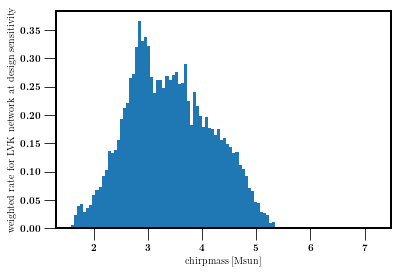

In [5]:
# to obtain the properties of the selected DCOtype you simply do this:

fDCO      = fdata['doubleCompactObjects']
#Stuff I need for cosmological integral


# at this moment we dont need to specify a mask, since our datafile has already taken this into account. 
DCOmask = [True]*(len(fDCO['Metallicity1'][...].squeeze()))
print(DCOmask)


metallicitySystems  = fDCO['Metallicity1'][...].squeeze()[DCOmask]  # Metallicity at ZAMS 
delayTimes          = fDCO['tform'][...].squeeze()[DCOmask] + \
                           fDCO['tc'][...].squeeze()[DCOmask]   # delay time 
tc                  = fDCO['tc'][...].squeeze()[DCOmask]  # coalescence time (or merger time)
M1              = fDCO['M1'][...].squeeze()[DCOmask]     # Compact object mass of star 1 
M2               = fDCO['M2'][...].squeeze()[DCOmask]    # Compact object mass of star 2 
m1zams              = fDCO['M1ZAMS'][...].squeeze()[DCOmask]   # Mass at ZAMS of star 1 
m2zams              = fDCO['M2ZAMS'][...].squeeze()[DCOmask]   # Mass at ZAMS of star 2 
separationzams      = fDCO['separationInitial'][...].squeeze()[DCOmask]   # separation at ZAMS of binary 


# we will use for this demo the weights from Star formation history model xyz = '000', these can be obtained using:
weights = fdata['weights_detected']['w_000']

# change this to formation weights by uncommenting the following line:
# weights = fDCO['weight']


# other models can be chosen too. (there are 28 options currently)


def chirpmass(m1, m2):
    numer = (m1*m2)**(3./5)
    denom = (m1+m2)**(1./5)
    
    return numer/denom

# and you can plot properties, e.g., the chirpmass distribution: 
chirpmass =chirpmass(m1=M1, m2=M2)


plt.hist(chirpmass, bins=100, weights=weights)
plt.xlabel('chirpmass [Msun]')
plt.ylabel('weighted rate for LVK network at design sensitivity')
plt.show()




### M1 more massive, M2 least massive:






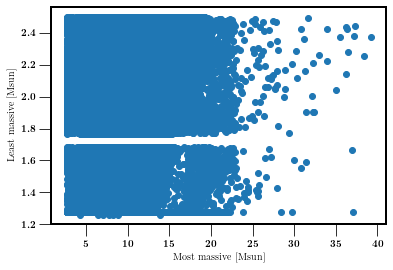

In [6]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1bh[maskm1heavier] = m1[maskm1heavier] 
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    
    return m1bh, m2bh # m1bh has all the heaviest systems



M_most_massive, M_least_massive = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)


plt.scatter(M_most_massive, M_least_massive)
plt.xlabel('Most massive [Msun]')
plt.ylabel('Least massive [Msun]')
plt.show()



### Metallicity 

the metallicity of each data point can be obtained with "metallicitySystems"
I used a total of 53 different metallicity bins, quoted in the bottem when printing "Data.metallicityGrid" 

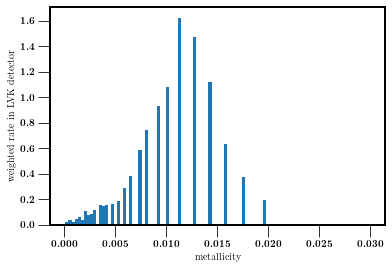

this mostly just shows my metallicity bins and where BHNS are originating from


In [7]:
# metallicitySystems = metallicitySystems
plt.hist(metallicitySystems, bins=100, weights=weights)
plt.xlabel('metallicity ')
plt.ylabel('weighted rate in LVK detector')
plt.show()




print('this mostly just shows my metallicity bins and where BHNS are originating from')

### Delay time  of each simulated data point in Myr

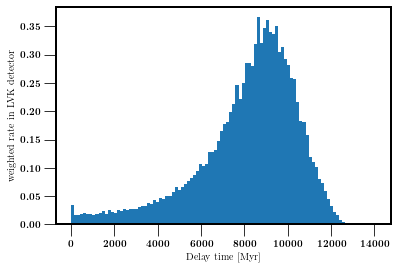

In [8]:


plt.hist(delayTimes, bins=100, weights=weights)
plt.xlabel('Delay time [Myr] ')
plt.ylabel('weighted rate in LVK detector')
plt.show()




# Spin models 


In [14]:
class COspin(object):
    """
    This class calculates the Black Hole (BH) or Neutron Star (NS) spin
    based on a given spin function/model 
    
    """
    
    
    def __init__(self, data_path=None, SFRDmodel='312'):
    
        self.path                = data_path
        if (self.path is None):
            print("Just to double check you create instance of ClassCOMPAS without path/Data")
        elif not  os.path.isfile(data_path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
        elif os.path.isfile(data_path):
            self.h5file           = h5.File(data_path)
            
            
        self.spin_model = None 
        self.whichweight = None 
        self.SFRDmodel = SFRDmodel  # SFRD model chosen for the weights 
    
        
    def convert_a_to_P_circular(separation, M1, M2):
        """calculate Period from separation
        separation is separation (needs to be given in astropy units)
        M1 and M2 are masses of the binary

        """
        G = const.G # [gr cm s^2]


        mu = G*(M1+M2)
        period = 2*np.pi * np.sqrt(separation**3/mu)


        return period   
        
        
    def setCOMPASData(self):
        """ reads in some of the COMPAS parameters needed from hdf5 file """
        
        fDCO      = self.h5file['doubleCompactObjects'] # hdf5 file with the DCO information
        fSN       = self.h5file['supernovae']  # hdf5 file with the SN information
        #
        self.M1 = fDCO['M1'][...].squeeze()   # Compact object mass [Msun] of the initially more massive star
        self.M2 = fDCO['M2'][...].squeeze()  # Compact object mass [Msun] of the initially less massive star
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()
        
        if self.whichweight =='DCOweights':
            self.weight  = fDCO['weight'][...].squeeze()  # system weights, these are representative of sampling that binary from the given metallicity in a galaxy.
        elif self.whichweight =='detected':
            self.weight  = fdata['weights_detected']['w_'+self.SFRDmodel]  # weights that account also for the detectability of the DCO and the star formation history (SFRD) 
        elif self.whichweight =='intrinsic':
            self.weight  = fdata['weights_intrinsic']['w_'+self.SFRDmodel]  # weights that account for the intrinsic rate (at redshift ~0) of the DCO for a given star formation history (SFRD) 
        
        
        
        self.seedsDCO = fDCO['seed'][...].squeeze()  # get the seeds in the DCO file 
        self.seedsSN = fSN['randomSeed'][...].squeeze()    # get the seeds in the SN file 
        maskSNdco = np.in1d(self.seedsSN,  self.seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
        whichSN = fSN['whichStar'][...].squeeze()[maskSNdco]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
        whichSN1 = whichSN[::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       

        self.separationPreSN2= fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  
        self.PeriodPreSN2 = convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=M1*u.Msun, M2=M2*u.Msun)  # obtain the Period before the SNe
        self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
        self.MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        
        self.st1 = fDCO['stellarType1'][...].squeeze()   # obtain the final stellar type of the Primary 
        self.st2 = fDCO['stellarType2'][...].squeeze()   # obtain the final stellar type of the Secondary
        
        self.spinM1 = np.zeros_like(self.M1)  # start by giving all primaries zero spin 
        self.spinM2 = np.zeros_like(self.M2)  # start by giving all secondaries zero spin 
        # did M1 form in the first SN?
        self.M1formedFirst =  (whichSN1==1) # mask that is 1 if the  compact object M1 formed first in the DCO
        # did M2 form in the first SN?
        self.M2formedFirst =  (whichSN1==2)  # mask that is 1 if the compact object M2 formed first in the DCO
        
        

    
    def QinSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 
        
        see Qin+18, approximation originally given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C 
        (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)
        
        """
        
        m_, c_ = -5./3, 0.5 # from Qin + 2018 

        # if BH & formed second, calculate spin with Qin+18 approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
        
        # # first mask super tight NSBH that will get spin 1
        maskSpin1 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin1 ==1)                        
        maskSpin2 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin2 ==1)
        self.spinM1[maskSpin1] = np.ones(np.sum(maskSpin1)) # fill with ones 
        self.spinM2[maskSpin2] = np.ones(np.sum(maskSpin2)) # fill with ones 
  
        
        # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
        maskChi_var1 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin1==1)
        self.spinM1[maskChi_var1] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var1])  + c_   
             
        maskChi_var2 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin2==1)
        self.spinM2[maskChi_var2] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var2])  + c_   
              
    
        return self.spinM1, self.spinM2

    
    
    def calculate_alpha_beta_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta):


        alpha = function_f_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha)
        beta  = function_f_Bavera21(m_WR, c1_beta,  c2_beta,  c3_beta)

        return alpha, beta

    def function_f_Bavera21(m_WR, c1, c2, c3):
        """
        m_WR with units using astropy


        """

        top = -c1
        bottom = c2 + np.exp(-c3*m_WR.to(u.Msun).value)

        f = top/bottom


        return f        
        
        
    def BaveraSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 

        based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
        """

        # numerical coefficients form text below Eq 2
        # we use the values at helium depletion, since we later on use the C/O core mass. 
        c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
        c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739
        
        alpha, beta = calculate_alpha_beta_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta)
        print(alpha, beta)        
        

        # if BH & formed second, calculate spin with Qin+18 approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
        # 
        first_term = (alpha[maskBH2_and_P_below_1Day] * (np.log10(period[maskBH2_and_P_below_1Day].to(u.d).value))**2) 
        second_term =  ( beta[maskBH2_and_P_below_1Day] * np.log10(period[maskBH2_and_P_below_1Day].to(u.d).value))  
        a_BH2[maskBH2_and_P_below_1Day]  =  first_term  + second_term  
        
        
#         # # first mask super tight NSBH that will get spin 1
#         maskSpin1 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin1 ==1)                        
#         maskSpin2 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin2 ==1)
#         self.spinM1[maskSpin1] = np.ones(np.sum(maskSpin1)) # fill with ones 
#         self.spinM2[maskSpin2] = np.ones(np.sum(maskSpin2)) # fill with ones 
  
        
#         # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
#         maskChi_var1 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin1==1)
#         self.spinM1[maskChi_var1] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var1])  + c_   
             
#         maskChi_var2 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin2==1)
#         self.spinM2[maskChi_var2] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var2])  + c_   
              
    
        return self.spinM1, self.spinM2

## 1. "Qin+18" 
#####  Approximate spin fit based on Qin+18, originally as given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)



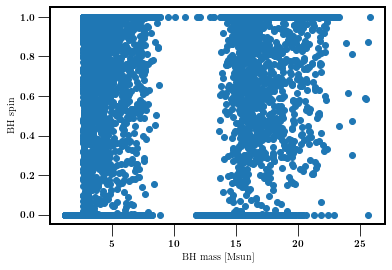

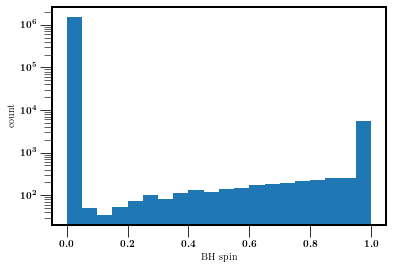

In [15]:

spin = COspin(data_path=path)  # set class 
spin.setCOMPASData() # reads in the COMPAS DCO parameters 
spinM1, spinM2  = spin.QinSpin()



plt.scatter(spin.M2, spin.spinM2)
plt.xlabel('BH mass [Msun]')
plt.ylabel('BH spin ')
plt.show()

plt.hist(spin.spinM2, bins=20)
plt.xlabel('BH spin')
plt.ylabel('count ')
plt.yscale('log')
plt.show()
